In [2]:
!git clone https://github.com/mylrcd/NeuralGCM.git
! pip install -U -q dinosaur-dycore gcsfs

fatal: destination path 'NeuralGCM' already exists and is not an empty directory.


#Def

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
import numpy as np
import pandas as pd
import scipy.ndimage
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

from dinosaur import coordinate_systems
from dinosaur import filtering
from dinosaur import primitive_equations
from dinosaur import scales
from dinosaur import sigma_coordinates
from dinosaur import spherical_harmonic
from dinosaur import time_integration
from dinosaur import vertical_interpolation


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

units = scales.units


def attach_data_array_units(array):
  attrs = dict(array.attrs)
  units = attrs.pop('units', None)
  if units in {'(0 - 1)', '%', '~'}:
    units = None
  if units is not None:
    data = scales.units.parse_expression(units) * array.data
  else:
    data = scales.units.dimensionless * array.data
  return xarray.DataArray(data, array.coords, array.dims, attrs=attrs)


def attach_xarray_units(ds):
  return ds.map(attach_data_array_units)


def xarray_nondimensionalize(ds):
  return xarray.apply_ufunc(scales.DEFAULT_SCALE.nondimensionalize, ds)


def xarray_to_gcm_dict(ds, var_names=None):
  if var_names is None:
    var_names = ds.keys()
  result = {}
  for var_name in var_names:
    data = ds[var_name].transpose(..., 'longitude', 'latitude').data
    if data.ndim == 2:  # missing level dimension
      data = data[np.newaxis, ...]
    result[var_name] = data
  return result


def slice_levels(output, level_indices):
  def get_horizontal(x):
    if x.shape[0] == 1:
      return x
    else:
      return x[level_indices, ...]
  return jax.tree.map(get_horizontal, output)






def state_to_xarray(state):

  longitude = np.linspace(0, 357.2, 255)
  latitude = np.linspace(-88.93, 89.03, 129)
  level = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875], dtype=np.int32)
  level1 = np.array([1], dtype=np.int32)


  ds = xr.Dataset(
      coords={
          "level": level,
          "longitude": longitude,
          "latitude": latitude,
      }
  )

  ds['divergence'] = (("level", "longitude", "latitude"), state.divergence)
  ds['vorticity'] = (("level",  "longitude", "latitude"), state.vorticity)
  ds['log_surface_pressure'] = (("level1", "longitude", "latitude"), state.log_surface_pressure)
  ds['temperature_deviation'] = (("level", "longitude", "latitude"), state.temperature_variation)
  ds['temperature'] = (( "level", "longitude", "latitude"), state.temperature_variation)
  ds['specific_humidity'] = (( "level", "longitude", "latitude"), state.tracers['specific_humidity'])
  ds['specific_cloud_ice_water_content'] = (("level", "longitude", "latitude"), state.tracers['specific_cloud_ice'])
  ds['specific_cloud_liquid_water_content'] = (("level", "longitude", "latitude"), state.tracers['specific_cloud_water'])

  return ds

2.5.1+cu124
12.4
False


In [4]:

def dynamical_core(encode, dt) :

  data = encode.isel(longitude=slice(0, -1))
  last_lat = data['latitude'][-1].values
  new_lat = np.append(data['latitude'].values, last_lat + 0.1)
  extended_data = data.reindex(latitude=new_lat, method=None)
  data = extended_data.fillna(extended_data.isel(latitude=-2))

  # simulation grid
  layers = 32
  ref_temp_si = 250 * units.degK
  model_coords = coordinate_systems.CoordinateSystem(
      spherical_harmonic.Grid.TL127(), #initilement : T170 ; ([256, 128]) :TL127 ,((((T85)))
      sigma_coordinates.SigmaCoordinates.equidistant(layers),
  )

  # timescales
  dt_si = dt * units.minute
  save_every = dt * units.minute
  total_time = dt * units.minute + save_every
  dfi_timescale = dt * units.minute

  # which levels to output
  output_level_indices = [layers // 4, layers // 2, 3*layers // 4, -1]



##################################################################################################################
  physics_specs = primitive_equations.PrimitiveEquationsSpecs.from_si()


  ref_temps = physics_specs.nondimensionalize(
      ref_temp_si * np.ones((model_coords.vertical.layers,))
  )

  #orography

  raw_orography = data.geopotential.isel(time=0, level=0).expand_dims(dim="level")

  desired_lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
  desired_lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])


  #####################################################################################
  orography = np.full((1, 255, 129), 1e-10)
  #####################################################################################

  ds_init = attach_xarray_units(data.compute().interp(latitude=desired_lat, longitude=desired_lon))
  ds_init['orography'] = attach_data_array_units(raw_orography.interp(latitude=desired_lat, longitude=desired_lon))
  ds_init['orography'] /= scales.GRAVITY_ACCELERATION
  """
  ds_nondim_init = xarray_nondimensionalize(ds_init)
  model_level_inputs = xarray_to_gcm_dict(ds_nondim_init)

  """"""
  orography_input = model_level_inputs.pop('orography')
  orography = model_coords.horizontal.to_modal(orography_input)
  orography = filtering.exponential_filter(model_coords.horizontal, order=2)(orography)"""




  # setup a simulation of the dry primitive equations
  eq = primitive_equations.PrimitiveEquations(
      ref_temps, orography, model_coords, physics_specs
  )

  # setup hyper-spectral filter for running between dycore time-steps
  res_factor = model_coords.horizontal.latitude_nodes / 128
  dt = physics_specs.nondimensionalize(dt_si)
  tau = physics_specs.nondimensionalize(8.6 / (2.4 ** np.log2(res_factor)) * units.hours)
  hyperdiffusion_filter = time_integration.horizontal_diffusion_step_filter(
      model_coords.horizontal, dt=dt, tau=tau, order=2
  )

  # digital filter initialization
  time_span = cutoff_period = physics_specs.nondimensionalize(dfi_timescale)
  dfi = jax.jit(time_integration.digital_filter_initialization(
      equation=eq,
      ode_solver=time_integration.imex_rk_sil3,
      filters=[hyperdiffusion_filter],
      time_span=time_span,
      cutoff_period=cutoff_period,
      dt=dt,
  ))



  # time integration & post-processing

  def nodal_prognostics_and_diagnostics(state):
    coords = model_coords.horizontal
    u_nodal, v_nodal = spherical_harmonic.vor_div_to_uv_nodal(
        coords, state.vorticity, state.divergence)
    geopotential_nodal = coords.to_nodal(
        primitive_equations.get_geopotential(
            state.temperature_variation,
            eq.reference_temperature,
            orography,
            model_coords.vertical,
        )
    )
    primitive_equations.get_geopotential
    vor_nodal = coords.to_nodal(state.vorticity)
    div_nodal = coords.to_nodal(state.divergence)
    sp_nodal = jnp.exp(coords.to_nodal(state.log_surface_pressure))
    tracers_nodal = {k: coords.to_nodal(v) for k, v in state.tracers.items()}
    t_nodal = (
        coords.to_nodal(state.temperature_variation)
        + ref_temps[:, np.newaxis, np.newaxis]
    )
    vertical_velocity_nodal = primitive_equations.compute_vertical_velocity(
        state, model_coords
    )
    state_nodal = {
        'u_component_of_wind': u_nodal,
        'v_component_of_wind': v_nodal,
        'temperature': t_nodal,
        'vorticity': vor_nodal,
        'divergence': div_nodal,
        'vertical_velocity': vertical_velocity_nodal,
        'geopotential': geopotential_nodal,
        'surface_pressure': sp_nodal,
        **tracers_nodal,
    }

    return slice_levels(state_nodal, output_level_indices)





  # temporal integration function
  inner_steps = int(save_every / dt_si)
  outer_steps = int(total_time / save_every)
  step_fn = time_integration.step_with_filters(
      time_integration.imex_rk_sil3(eq, dt),
      [hyperdiffusion_filter],
  )
  integrate_fn = jax.jit(time_integration.trajectory_from_step(
      step_fn,
      outer_steps=outer_steps,
      inner_steps=inner_steps,
      start_with_input=True,
      post_process_fn=nodal_prognostics_and_diagnostics,
  ))


    # build initial state
  tracers = {
      'specific_cloud_water': data['specific_cloud_liquid_water_content'].isel(time=0),
      'specific_cloud_ice': data['specific_cloud_ice_water_content'].isel(time=0),
      'specific_humidity': data['specific_humidity'].isel(time=0),
  }


  raw_init_state = primitive_equations.State(
      vorticity = data['vorticity'].isel(time=0).data,
      divergence = data['divergence'].isel(time=0).data,
      temperature_variation=data['temperature_deviation'].isel(time=0).data,
      log_surface_pressure=data['log_surface_pressure'].isel(time=0, level=0).expand_dims(dim="level").data,
      tracers={k: v.data for k, v in tracers.items()},
  )

  return dfi, raw_init_state, integrate_fn, model_coords, ds_init, orography, physics_specs, save_every, outer_steps, output_level_indices



def dynamical_core2(dfi, raw_init_state, integrate_fn):

  dfi_init_state = jax.block_until_ready(dfi(raw_init_state))
  out_state, trajectory = jax.block_until_ready(integrate_fn(dfi_init_state))

  return out_state, trajectory


#Init

In [5]:
e = xr.open_dataset("/content/full_encoded_data.nc")
dfi, raw_init_state, integrate_fn, model_coords, ds_init, orography, physics_specs, save_every, outer_steps, output_level_indices = dynamical_core(e, 5)
out_state, _ = dynamical_core2(dfi, raw_init_state, integrate_fn)
out_state = state_to_xarray(out_state)




def trajectory_to_xarray(trajectory):

    # convert units back to SI
    target_units = {k: v.data.units for k, v in ds_init.items()}
    target_units |= {
        'vorticity': units('1/s'),
        'divergence': units('1/s'),
        'geopotential': units('m^2/s^2'),
        'vertical_velocity': units('1/s'),
    }

    ###################################################
    target_units['surface_pressure'] = units('Pa')
    ###################################################
    target_units['specific_cloud_water'] = units('kg/kg')
    ###################################################
    target_units['specific_cloud_ice'] = units('kg/kg')
    ###################################################

    orography_nodal = jax.device_put(model_coords.horizontal.to_nodal(orography), device=jax.devices('cpu')[0])
    trajectory_cpu = jax.device_put(trajectory, device=jax.devices('cpu')[0])

    traj_nodal_si = {
        k: physics_specs.dimensionalize(v, target_units[k]).magnitude
        for k, v in trajectory_cpu.items()
    }


    # build xarray
    times = float(save_every / units.hour) * np.arange(outer_steps)
    lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
    lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

    dims = ('time', 'sigma', 'longitude', 'latitude')
    ds_result = xarray.Dataset(
        data_vars={
            k: (dims, v) for k, v in traj_nodal_si.items() if k != 'surface_pressure'
        },
        coords={
            'longitude': lon,
            'latitude': lat,
            'sigma': model_coords.vertical.centers[output_level_indices],
            'time': times,
            'orography': (('longitude', 'latitude'), orography_nodal.squeeze()),
        },
    ).assign(
        surface_pressure=(
            ('time', 'longitude', 'latitude'),
            traj_nodal_si['surface_pressure'].squeeze(axis=-3),
        )
    )
    return ds_result



In [6]:
e

<xarray.Dataset> Size: 232MB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 32, time: 5)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 21MB ...
    vorticity                            (level, time, longitude, latitude) float32 21MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 21MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 21MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 655kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 655kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 21MB ...
    temperature                          (time, level, longitude, latitude) float32 21MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 21MB ...

In [7]:
out_state

<xarray.Dataset> Size: 30MB
Dimensions:                              (level: 32, longitude: 255,
                                          latitude: 129, level1: 1)
Coordinates:
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * longitude                            (longitude) float64 2kB 0.0 ... 357.2
  * latitude                             (latitude) float64 1kB -88.93 ... 89.03
Dimensions without coordinates: level1
Data variables:
    divergence                           (level, longitude, latitude) float32 4MB ...
    vorticity                            (level, longitude, latitude) float32 4MB ...
    log_surface_pressure                 (level1, longitude, latitude) float32 132kB ...
    temperature_deviation                (level, longitude, latitude) float32 4MB ...
    temperature                          (level, longitude, latitude) float32 4MB ...
    specific_humidity                    (level, longitude, latitude) float32 4MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 4MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 4MB ...

#Iter

In [8]:
ds_list = []

for i in range(1, 5):

  tracers = {
      'specific_cloud_water': out_state['specific_cloud_liquid_water_content'],
      'specific_cloud_ice': out_state['specific_cloud_ice_water_content'],
      'specific_humidity': out_state['specific_humidity'],
      }


  raw_init_state = primitive_equations.State(
      vorticity = out_state['vorticity'].data,
      divergence = out_state['divergence'].data,
      temperature_variation=out_state['temperature_deviation'].data,
      log_surface_pressure=out_state['log_surface_pressure'].data,
      tracers={k: v.data for k, v in tracers.items()},
  )

  out_state, trajectory = dynamical_core2(dfi, raw_init_state, integrate_fn)
  out_state = state_to_xarray(out_state)

  ds_out = trajectory_to_xarray(trajectory)
  print(ds_out["time"].values)

  ds_list.append(ds_out.sel(time=1, method='nearest'))

ds_final = xr.concat(ds_list, dim="time")

ds_final

[0.         0.08333333]
[0.         0.08333333]
[0.         0.08333333]
[0.         0.08333333]


<xarray.Dataset> Size: 22MB
Dimensions:               (time: 4, sigma: 4, longitude: 256, latitude: 128)
Coordinates:
  * longitude             (longitude) float64 2kB 0.0 1.406 ... 357.2 358.6
  * latitude              (latitude) float64 1kB -88.93 -87.54 ... 87.54 88.93
  * sigma                 (sigma) float64 32B 0.2656 0.5156 0.7656 0.9844
  * time                  (time) float64 32B 0.08333 0.08333 0.08333 0.08333
    orography             (longitude, latitude) float32 131kB ...
Data variables:
    divergence            (time, sigma, longitude, latitude) float32 2MB ...
    geopotential          (time, sigma, longitude, latitude) float32 2MB ...
    specific_cloud_ice    (time, sigma, longitude, latitude) float32 2MB ...
    specific_cloud_water  (time, sigma, longitude, latitude) float32 2MB ...
    specific_humidity     (time, sigma, longitude, latitude) float32 2MB ...
    temperature           (time, sigma, longitude, latitude) float32 2MB ...
    u_component_of_wind   (time, sigma, longitude, latitude) float32 2MB ...
    v_component_of_wind   (time, sigma, longitude, latitude) float32 2MB ...
    vertical_velocity     (time, sigma, longitude, latitude) float32 2MB ...
    vorticity             (time, sigma, longitude, latitude) float32 2MB ...
    surface_pressure      (time, longitude, latitude) float32 524kB ...

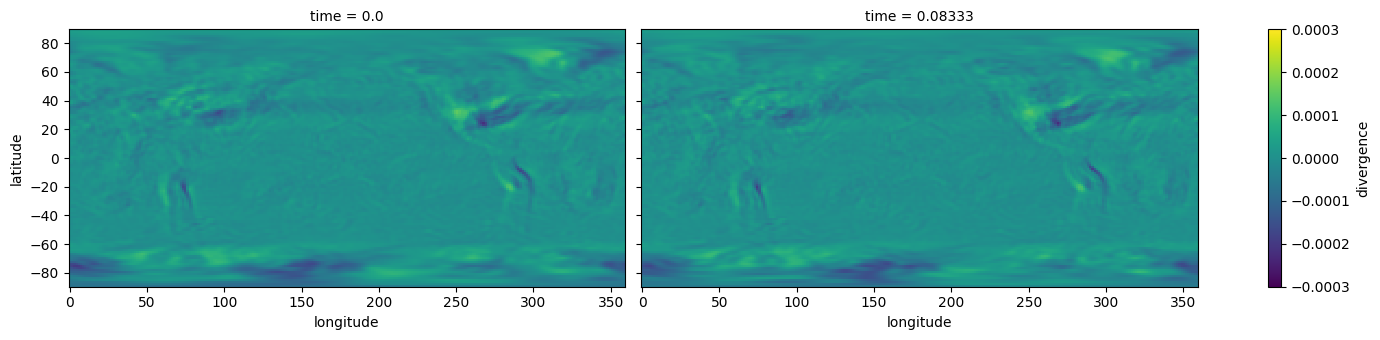

In [9]:
ds_out.divergence.isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=2,
    aspect=2, size=3.5,
    cmap='viridis', vmin=-3e-4, vmax=3e-4,
)